<h1>Heart disease Dataset, NN, Random Optimization</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,recall_score, balanced_accuracy_score,f1_score, mean_squared_error
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import mlrose_hiive
import dataframe_image as dfi

import time
import warnings
warnings.filterwarnings('ignore')

<h3>Data Cleanup & Split</h3>

In [2]:
data = pd.read_csv('../data/heartFailurePrediction/heart.csv', sep=',')
# print(data.shape)
# data.head(5)
# get data info
print(data.shape)
data.info()

(918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [3]:
# Select numerical variables
data_X = data.drop("HeartDisease", axis=1)
# data_X = data_X.drop("Id", axis=1)
numeric = data_X.select_dtypes(exclude=object).columns
#numeric.remove('quality')
print(type(numeric))
for col in numeric:
    data_X[col] = StandardScaler().fit_transform(data_X[[col]])

data = data_X.join(data['HeartDisease'])


<class 'pandas.core.indexes.base.Index'>


In [4]:
# Dealing with the outliers (RestingBP)
q1 = data['RestingBP'].quantile(0.25)
q3 = data['RestingBP'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr

u = data[(data['RestingBP'] >= Upper_tail) | (data['RestingBP'] <= Lower_tail)]  # | means "or"
u = pd.DataFrame(u)
print('Outliers on RestingBP:')
u.value_counts(u['HeartDisease'])

Outliers on RestingBP:


HeartDisease
1    29
0    13
dtype: int64

In [5]:
# Median imputation (RestingBP)
med = np.median(data['RestingBP'])
for i in data['RestingBP']:
    if i > Upper_tail or i < Lower_tail:
            data['RestingBP'] = data['RestingBP'].replace(i, med)

In [6]:
# Dealing with outliers (Cholesterol)
q1 = data['Cholesterol'].quantile(0.25)
q3 = data['Cholesterol'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr

u = data[(data['Cholesterol'] >= Upper_tail) | (data['Cholesterol'] <= Lower_tail)]  # | means "or"
u = pd.DataFrame(u)
print('Outliers on Cholesterol:')
u.value_counts(data['HeartDisease'])

Outliers on Cholesterol:


HeartDisease
1    158
0     25
dtype: int64

In [7]:
z = data[data['Cholesterol'] == 0]
z = pd.DataFrame(z)
print('Outliers on Cholesterol equal to 0:')
z.value_counts(data['HeartDisease'])

Outliers on Cholesterol equal to 0:


Series([], dtype: int64)

In [8]:
# Median imputation (Cholesterol) just on upper tail
med = np.median(data['Cholesterol'])
for i in data['Cholesterol']:
    if i > Upper_tail:
            data['Cholesterol'] = data['Cholesterol'].replace(i, med)

In [9]:
# data_encoded = data.apply(LabelEncoder().fit_transform)
# data_encoded.head()

# Select numerical variables
objList = data.select_dtypes(include=object).columns

le = LabelEncoder()
for feat in objList:
    data[feat] = le.fit_transform(data[feat].astype(str))

In [10]:
data.shape

(918, 12)

In [11]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,-0.551341,1,1.382928,0,-0.832432,2,0
1,-0.478484,0,2,1.491752,-0.171961,-0.551341,1,0.754157,0,0.105664,1,1
2,-1.751359,1,1,-0.129513,0.770188,-0.551341,2,-1.525138,0,-0.832432,2,0
3,-0.584556,0,0,0.302825,0.139040,-0.551341,1,-1.132156,1,0.574711,1,1
4,0.051881,1,2,0.951331,-0.034755,-0.551341,1,-0.581981,0,-0.832432,2,0


In [12]:
data.HeartDisease.value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [13]:
# stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

print("Splitting StratifiedShuffleSplit into train/test")

split = StratifiedShuffleSplit(n_splits=1 , test_size=0.3, random_state=15)
for train_ind, test_ind in split.split(data, data["HeartDisease"]):
    strat_train_set = data.loc[train_ind]
    strat_test_set = data.loc[test_ind]
    
train_set = strat_train_set
test_set = strat_test_set

y_train = train_set[["HeartDisease"]]
X_train = train_set.drop("HeartDisease", axis=1)
y_test = test_set[["HeartDisease"]]
X_test = test_set.drop("HeartDisease", axis=1)

y = data[["HeartDisease"]]
X = data.drop("HeartDisease", axis=1)

print("Setting up global variables")
classifier_accuracy = np.zeros(5)
time_train = np.zeros(5)
time_infer = np.zeros(5)
#print(X[:10])

Splitting StratifiedShuffleSplit into train/test
Setting up global variables


In [14]:
def model_evaluation(model, X_train, y_train, X_test, y_test):
    
    print('Starting ...')
    
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.fit_transform(X_test)
    print("Scaling process is done ...")
    
    print("**********************************")
    
    print("Model building process is started ...")
    mod = model.fit(X_train, y_train)
    mod_pred = model.predict(X_test)
    print("Model creation process is done ...")
    
    print("**********************************")
    print("Evaluation of the Model")
    print("***********************************")
    
    print("Classification report of the Model: \n {}".format(classification_report(y_test, mod_pred)))
    print("Confusion Matrix of the given Model: \n {}".format(confusion_matrix(y_test, mod_pred)))
    print("f1_Micro score of the Model: \n{}".format(f1_score(y_test, mod_pred, average='micro')))
    
    print("Evaluation process is done ...")
    
    print("***********************************************")
    
    pass

<h3>Old Neural Network</h3>

In [15]:
clf_nn = MLPClassifier(hidden_layer_sizes=(4, 4), random_state=33, max_iter=1000)
clf_nn.fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)
nn_accuracy = recall_score(y_test, y_pred, )
print('recall_score of neural network without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))

recall_score of neural network without hyperparameter tuning is 87.58%


In [117]:
# Define grid for grid search after observing validation curves
param_grid = {'learning_rate_init': np.logspace(-3, -1, 3), 'hidden_layer_sizes': [4]}
clf_nn_g = GridSearchCV(clf_nn, param_grid=param_grid, scoring='recall', cv=5)

t0 = time.time()
clf_nn_g.fit(X_train, y_train)
t1 = time.time()
time_train[1] = t1 - t0
print('Completed training in %f seconds' % time_train[1])
best_clf_nn = clf_nn_g
best_params = clf_nn_g.best_params_
print("Best parameters set found on development set:")
print(best_params)

start_time = time.time()
classifier_accuracy[1] = recall_score(y_test, clf_nn_g.predict(X_test), average='micro')
end_time = time.time()
time_infer[1] = end_time-start_time
print("recall_score score for best Neural Network:", classifier_accuracy[1])
print('Completed training in %f seconds' % time_train[1])

Completed training in 5.162079 seconds
Best parameters set found on development set:
{'hidden_layer_sizes': 4, 'learning_rate_init': 0.1}
recall_score score for best Neural Network: 0.8659420289855072
Completed training in 5.162079 seconds


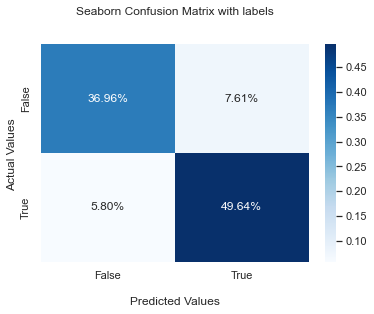

In [133]:
cf_matrix= confusion_matrix(y_test, clf_nn_g.predict(X_test))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
fig = ax.get_figure()
fig.savefig('../images/NN/heart_nn_cf.png')
plt.show()

In [119]:
model_evaluation(best_clf_nn, X_train, y_train, X_test, y_test)

Starting ...
Scaling process is done ...
**********************************
Model building process is started ...
Model creation process is done ...
**********************************
Evaluation of the Model
***********************************
Classification report of the Model: 
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       123
           1       0.87      0.90      0.88       153

    accuracy                           0.87       276
   macro avg       0.87      0.86      0.86       276
weighted avg       0.87      0.87      0.87       276

Confusion Matrix of the given Model: 
 [[102  21]
 [ 16 137]]
f1_Micro score of the Model: 
0.8659420289855072
Evaluation process is done ...
***********************************************


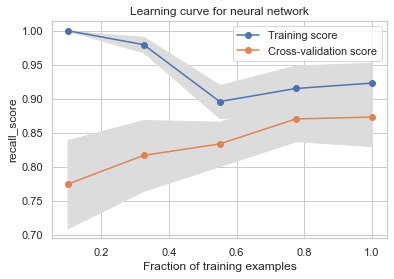

In [127]:
train_sizes = np.linspace(0.1, 1.0, 5)
clf_nn_l = MLPClassifier(random_state=33, max_iter=2000, hidden_layer_sizes=best_clf_nn.best_params_['hidden_layer_sizes'], learning_rate_init=best_clf_nn.best_params_['learning_rate_init'])
_, train_scores, test_scores = learning_curve(clf_nn_l, X_train, y_train, train_sizes=train_sizes, scoring='recall', cv=5)

param_range=np.linspace(0.1, 1.0, 5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gainsboro")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title('Learning curve for neural network')
plt.xlabel('Fraction of training examples')
plt.ylabel("recall_score")
plt.legend(loc="best")
plt.grid(visible=True)
plt.savefig('../images/NN/heart_nn_lc.png')
plt.show()

<p> Best parameters set found on development set:
{'hidden_layer_sizes': 4, 'learning_rate_init': 0.1}
recall_score score for best Neural Network: 0.8659420289855072
Completed training in 5.162079 seconds</p>

<h3>Back Propogation using Mlrose Hiive  </h3>

In [128]:
"""
Back Prop Case
"""
bp_clf = mlrose_hiive.NeuralNetwork(hidden_nodes=[4,4], activation='relu',
                           algorithm = 'gradient_descent',
                           early_stopping = True,
                           max_attempts = 100,
                           max_iters = 10000,
                           bias = True,
                           learning_rate = .001,
                           restarts=0, curve = True, random_state=44)

bp_clf.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)

NeuralNetwork(algorithm='gradient_descent', curve=True, early_stopping=True,
              hidden_nodes=[4, 4], learning_rate=0.001, max_attempts=100,
              max_iters=10000, random_state=44)

Setting up GD variables
0.1
fit_time = 0.235673189163208
0.01
fit_time = 0.21515703201293945
0.001
fit_time = 21.699182271957397
0.0001
fit_time = 21.347266912460327


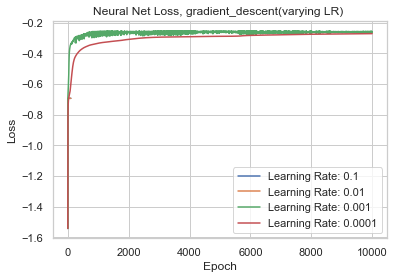

In [20]:
print("Setting up GD variables")
GD_classifier_accuracy = np.zeros(4)
GD_time_train = np.zeros(4)
GD_time_infer = np.zeros(4)


j=0
for i in [0.1,0.01,0.001, 0.0001]:
    print(i)
    
    clf_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'gradient_descent', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = i,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
#                                  pop_size=500,
#                                  mutation_prob=0.1
                                        curve=True)
    time_start = time.time()
    #nn_model5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    clf_gd.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    fit_time = time.time()
    GD_time_train[j] = fit_time-time_start
    print(f'fit_time = {fit_time-time_start}')
    
    start_time = time.time()
    GD_classifier_accuracy[j] = recall_score(pd.get_dummies(y_test.values.ravel()).values, clf_gd.predict(X_test), average='macro')
    end_time = time.time()
    GD_time_infer[j] = end_time-start_time

    plt.plot(clf_gd.fitness_curve[:],label="Learning Rate: "+str(i))
    plt.legend()
    fig=plt.gcf()
    j+=1
plt.title("Neural Net Loss, gradient_descent(varying LR) ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../images/NN/nn_gd_lc.png')
plt.show()

In [21]:
GD_classifier_accuracy

array([0.5       , 0.5       , 0.84289813, 0.8616292 ])

<h3>Setting up Global variables</h3>

In [23]:
print("Setting up Global variables")
ALL_classifier_test_accuracy = np.zeros(4)
ALL_classifier_train_accuracy = np.zeros(4)
ALL_time_train = np.zeros(4)
ALL_time_infer = np.zeros(4)

Setting up Global variables


<h3> Best GD </h3>

In [24]:
best_clf_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'gradient_descent', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.0001,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
#                                  pop_size=500,
#                                  mutation_prob=0.1
                                        curve=True)
print('Running best_clf_gd')
time_start = time.time()
best_clf_gd.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
fit_time = time.time()
gd_time_train = fit_time-time_start
print(f'fit_time = {fit_time-time_start}')
gd_classifier_train_accuracy= recall_score(pd.get_dummies(y_train.values.ravel()).values, best_clf_gd.predict(X_train), average='macro')   
start_time = time.time()
gd_classifier_test_accuracy = recall_score(pd.get_dummies(y_test.values.ravel()).values, best_clf_gd.predict(X_test), average='macro')
end_time = time.time()
gd_time_infer = end_time-start_time

ALL_classifier_test_accuracy[0]=gd_classifier_test_accuracy
ALL_classifier_train_accuracy[0]=gd_classifier_train_accuracy
ALL_time_train[0]=gd_time_train
ALL_time_infer[0]=gd_time_infer

Running best_clf_gd
fit_time = 21.056029796600342


In [42]:
gd_classifier_train_accuracy, gd_classifier_test_accuracy, gd_time_train, gd_time_infer

(0.8836482308485056,
 0.8616292045273394,
 21.37649941444397,
 0.003001689910888672)

<h1>Genetic ALG using Mlrose Hiive  </h1>
<h3> Tunning GA Params</h3>

Setting up GA variables
0.1
fit_time = 226.61350965499878
0.01
fit_time = 224.80314373970032
0.001
fit_time = 224.98323512077332


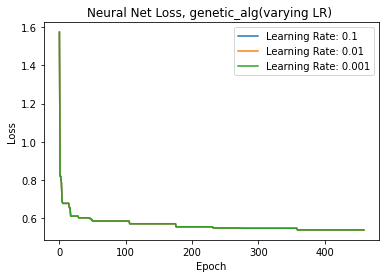

In [31]:
#Tuning learning Rate
print("Setting up GA variables")
GA2_classifier_accuracy = np.zeros(3)
GA_time_train = np.zeros(3)
GA_time_infer = np.zeros(3)


j=0
for i in [0.1,0.01,0.001]:
    print(i)
    
    clf_ga = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = i,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
                                 pop_size=500,
                                 mutation_prob=0.1, curve=True)
    time_start = time.time()
    #nn_model5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    clf_ga.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    fit_time = time.time()
    GA_time_train[j] = fit_time-time_start
    print(f'fit_time = {fit_time-time_start}')
    
    start_time = time.time()
    GA2_classifier_accuracy[j] = recall_score(pd.get_dummies(y_test.values.ravel()).values, clf_ga.predict(X_test), average='macro')
    end_time = time.time()
    GA_time_infer[j] = end_time-start_time

    plt.plot(clf_ga.fitness_curve[:,0],label="Learning Rate: "+str(i))
    plt.legend()
    fig=plt.gcf()
    j+=1
plt.title("Neural Net Loss, genetic_alg(varying LR) ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../images/NN/nn2_ga_lc.png')
plt.show()

In [32]:
GA2_classifier_accuracy

array([0.68555715, 0.68555715, 0.68555715])

Setting up GA variables
500
fit_time = 258.57391452789307
1000
fit_time = 443.37038588523865
1500
fit_time = 893.1663725376129
2000
fit_time = 1065.2315242290497


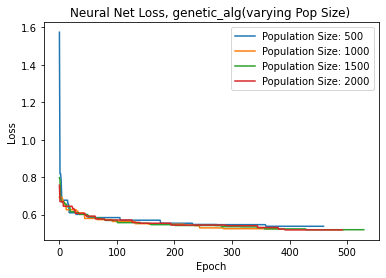

In [16]:
#Tuning Population Size
print("Setting up GA variables")
GA_classifier_accuracy = np.zeros(5)
GA_time_train = np.zeros(5)
GA_time_infer = np.zeros(5)


j=0
for i in [500,1000, 1500, 2000]:
    print(i)
    
    clf_ga = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
                                 pop_size=i,
                                 mutation_prob=0.1, curve=True)
    time_start = time.time()
    #nn_model5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    clf_ga.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    fit_time = time.time()
    GA_time_train[j] = fit_time-time_start
    print(f'fit_time = {fit_time-time_start}')
    
    start_time = time.time()
    GA_classifier_accuracy[j] = recall_score(pd.get_dummies(y_test.values.ravel()).values, clf_ga.predict(X_test), average='macro')
    end_time = time.time()
    GA_time_infer[j] = end_time-start_time

    plt.plot(clf_ga.fitness_curve[:,0],label="Population Size: "+str(i))
    plt.legend()
    fig=plt.gcf()
    j+=1
plt.title("Neural Net Loss, genetic_alg(varying Pop Size) ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../images/NN/nn_ga_lc.png')
plt.show()

In [19]:
GA_classifier_accuracy

array([0.68555715, 0.71170094, 0.73051172, 0.74525745, 0.        ])

<h3> Best GA Neural Network</h3>

In [25]:
best_clf_ga = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 100000,
                                 random_state = 44,
                                 pop_size=10,
                                 mutation_prob=0.1, curve=True)
print('Running best_clf_ga')
time_start = time.time()
best_clf_ga.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
fit_time = time.time()
ALL_time_train[1] = fit_time-time_start
print(f'fit_time = {fit_time-time_start}')
ALL_classifier_train_accuracy[1] = recall_score(pd.get_dummies(y_train.values.ravel()).values, best_clf_ga.predict(X_train), average='macro')   
start_time = time.time()
ALL_classifier_test_accuracy[1] = recall_score(pd.get_dummies(y_test.values.ravel()).values, best_clf_ga.predict(X_test), average='macro')
end_time = time.time()
ALL_time_infer[1] = end_time-start_time

Running best_clf_ga
fit_time = 112.24174380302429


In [26]:
ALL_classifier_train_accuracy

array([0.88364823, 0.77183099, 0.        , 0.        ])

Setting up GA variables
0.1
fit_time = 228.74109888076782
0.5
fit_time = 143.1023371219635
0.9
fit_time = 59.16965460777283


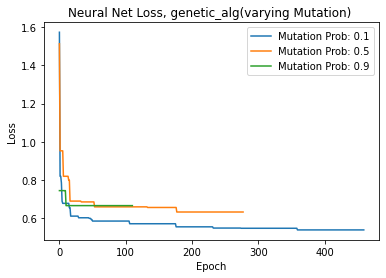

In [35]:
print("Setting up GA variables")
GA3_classifier_accuracy = np.zeros(3)
GA_time_train = np.zeros(3)
GA_time_infer = np.zeros(3)


j=0
for i in [0.1, 0.5, 0.9]:
    print(i)
    
    clf_ga = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
                                 pop_size=500,
                                 mutation_prob=i, curve=True)
    time_start = time.time()
    #nn_model5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    clf_ga.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    fit_time = time.time()
    GA_time_train[j] = fit_time-time_start
    print(f'fit_time = {fit_time-time_start}')
    
    start_time = time.time()
    GA3_classifier_accuracy[j] = recall_score(pd.get_dummies(y_test.values.ravel()).values, clf_ga.predict(X_test), average='macro')
    end_time = time.time()
    GA_time_infer[j] = end_time-start_time

    plt.plot(clf_ga.fitness_curve[:,0],label="Mutation Prob: "+str(i))
    plt.legend()
    fig=plt.gcf()
    j+=1
plt.title("Neural Net Loss, genetic_alg(varying Mutation) ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../images/NN/nn3_ga_lc.png')
plt.show()

In [36]:
GA3_classifier_accuracy

array([0.68555715, 0.58584409, 0.51881078])

<h1>Random Hill Climb using Mlrose Hiive  </h1>
<h3> Tunning RHC Params</h3>

Setting up RHC variables
0.1
fit_time = 235.90556621551514
0.01
fit_time = 675.7612900733948
0.001
fit_time = 689.7667634487152


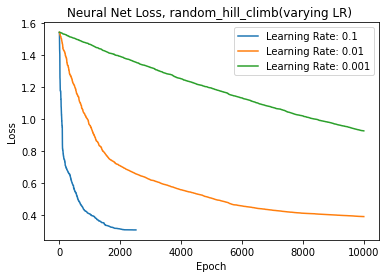

In [21]:
#Tunning Learning Rate
print("Setting up RHC variables")
RHC2_classifier_accuracy = np.zeros(3)
RHC_time_train = np.zeros(3)
RHC_time_infer = np.zeros(3)


j=0
for i in [0.1, 0.01, 0.001]:
    print(i)
    
    clf_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'random_hill_climb', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = i,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
#                                  pop_size=200,
                                 restarts =50, curve=True)
    time_start = time.time()
    #nn_model5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    clf_rhc.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    fit_time = time.time()
    RHC_time_train[j] = fit_time-time_start
    print(f'fit_time = {fit_time-time_start}')
    
    start_time = time.time()
    RHC2_classifier_accuracy[j] = recall_score(pd.get_dummies(y_test.values.ravel()).values, clf_rhc.predict(X_test), average='macro')
    end_time = time.time()
    RHC_time_infer[j] = end_time-start_time

    plt.plot(clf_rhc.fitness_curve[:,0],label="Learning Rate: "+str(i))
    plt.legend()
    fig=plt.gcf()
    j+=1
plt.title("Neural Net Loss, random_hill_climb(varying LR) ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../images/NN/nn2_rhc_lc.png')
plt.show()

In [22]:
RHC2_classifier_accuracy

array([0.82639885, 0.83126096, 0.53666507])

Setting up RHC variables
10
fit_time = 176.9387333393097
100
fit_time = 1466.3315353393555
200
fit_time = 2827.940764904022


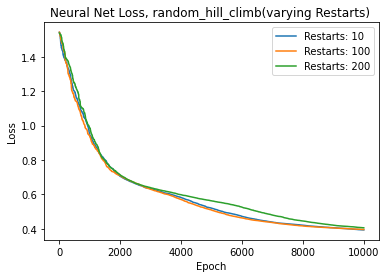

In [18]:
#Tunning Restarts
print("Setting up RHC variables")
RHC_classifier_accuracy = np.zeros(3)
RHC_time_train = np.zeros(3)
RHC_time_infer = np.zeros(3)


j=0
for i in [10, 100, 200]:
    print(i)
    
    clf_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'random_hill_climb', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.01,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
#                                  pop_size=200,
                                 restarts =i, curve=True)
    time_start = time.time()
    #nn_model5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    clf_rhc.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    fit_time = time.time()
    RHC_time_train[j] = fit_time-time_start
    print(f'fit_time = {fit_time-time_start}')
    
    start_time = time.time()
    RHC_classifier_accuracy[j] = recall_score(pd.get_dummies(y_test.values.ravel()).values, clf_rhc.predict(X_test), average='macro')
    end_time = time.time()
    RHC_time_infer[j] = end_time-start_time

    plt.plot(clf_rhc.fitness_curve[:,0],label="Restarts: "+str(i))
    plt.legend()
    fig=plt.gcf()
    j+=1
plt.title("Neural Net Loss, random_hill_climb(varying Restarts) ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../images/NN/nn_rhc_lc2.png')
plt.show()

In [20]:
RHC_classifier_accuracy

array([0.82552208, 0.83126096, 0.85979595])

<h3> Best RHC Neural Network</h3>

In [27]:
best_clf_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'random_hill_climb', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.01,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
#                                  pop_size=200,
                                 restarts =200, curve=True)
print('Running best_clf_rhc')
time_start = time.time()
best_clf_rhc.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
fit_time = time.time()
ALL_time_train[2] = fit_time-time_start
print(f'fit_time = {fit_time-time_start}')
ALL_classifier_train_accuracy[2] = recall_score(pd.get_dummies(y_train.values.ravel()).values, best_clf_rhc.predict(X_train), average='macro')   
start_time = time.time()
ALL_classifier_test_accuracy[2] = recall_score(pd.get_dummies(y_test.values.ravel()).values, best_clf_rhc.predict(X_test), average='macro')
end_time = time.time()
ALL_time_infer[2] = end_time-start_time

Running best_clf_rhc
fit_time = 2824.1750597953796


In [28]:
ALL_classifier_test_accuracy

array([0.8616292 , 0.76893034, 0.85979595, 0.        ])

<h1>Simulated Annealing using Mlrose Hiive  </h1>
<h3> Tunning SA Params</h3>

Setting up SA variables
0.1
fit_time = 17.368900537490845
0.01
fit_time = 18.87668776512146
0.001
fit_time = 19.29150080680847
0.0001
fit_time = 19.244408130645752


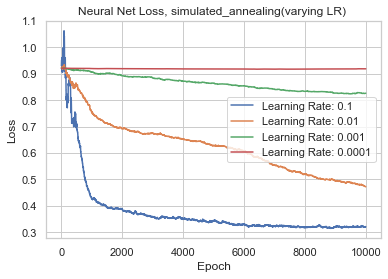

In [36]:
print("Setting up SA variables")
SA2_classifier_accuracy = np.zeros(4)
SA_time_train = np.zeros(4)
SA_time_infer = np.zeros(4)


j=0
for i in [0.1,0.01,0.001, 0.0001]:
    print(i)
    
    clf_sa = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu',
                                 algorithm = 'simulated_annealing', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = i,
                                 early_stopping = True,
#                                  max_attempts = 100,
                                 random_state = 42,
                                 schedule= mlrose_hiive.GeomDecay(), curve=True)
    time_start = time.time()
    #nn_model5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    clf_sa.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    fit_time = time.time()
    SA_time_train[j] = fit_time-time_start
    print(f'fit_time = {fit_time-time_start}')
    
    start_time = time.time()
    SA2_classifier_accuracy[j] = recall_score(pd.get_dummies(y_test.values.ravel()).values, clf_sa.predict(X_test), average='macro')
    end_time = time.time()
    SA_time_infer[j] = end_time-start_time

    plt.plot(clf_sa.fitness_curve[:,0],label="Learning Rate: "+str(i))
    plt.legend()
    fig=plt.gcf()
    j+=1
#fig.set_size_inches(10,6)
plt.title("Neural Net Loss, simulated_annealing(varying LR) ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../images/NN/nn2_sa_lc.png')
plt.show()

In [37]:
SA2_classifier_accuracy

array([0.87533875, 0.80934162, 0.47050853, 0.48605133])

Setting up SA variables
1.0
fit_time = 16.965664386749268
1.0
fit_time = 19.176520347595215
1.0
fit_time = 16.967281579971313


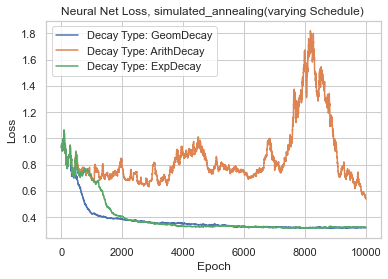

In [77]:
print("Setting up SA variables")
SA3_classifier_accuracy = np.zeros(3)
SA3_time_train = np.zeros(3)
SA3_time_infer = np.zeros(3)


j=0
for i in [mlrose_hiive.GeomDecay(),mlrose_hiive.ArithDecay(),mlrose_hiive.ExpDecay()]:
    print(i)
    
    clf_sa = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu',
                                 algorithm = 'simulated_annealing', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
#                                  max_attempts = 100,
                                 random_state = 42,
                                 schedule= i, curve=True)
    time_start = time.time()
    #nn_model5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    clf_sa.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    fit_time = time.time()
    SA3_time_train[j] = fit_time-time_start
    print(f'fit_time = {fit_time-time_start}')
    
    start_time = time.time()
    SA3_classifier_accuracy[j] = recall_score(pd.get_dummies(y_test.values.ravel()).values, clf_sa.predict(X_test), average='macro')
    end_time = time.time()
    SA3_time_infer[j] = end_time-start_time
    if j== 0:
        text= 'GeomDecay'
    if j== 1:
        text= 'ArithDecay'
    if j== 2:
        text= 'ExpDecay'
        

    plt.plot(clf_sa.fitness_curve[:,0],label="Decay Type: "+ text)
    plt.legend()
    fig=plt.gcf()
    j+=1
#fig.set_size_inches(10,6)
plt.title("Neural Net Loss, simulated_annealing(varying Schedule) ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../images/NN/nn_sa_decay_lc.png')
plt.show()

In [76]:
SA3_classifier_accuracy

array([0.87533875, 0.71927308, 0.86808545])

Setting up SA variables
0.05
fit_time = 16.964277982711792
0.1
fit_time = 17.245786428451538
0.5
fit_time = 17.83620262145996
1
fit_time = 17.33298349380493
3
fit_time = 17.526711463928223
5
fit_time = 17.278138875961304
6
fit_time = 18.996888399124146
8
fit_time = 17.380959272384644
9
fit_time = 16.9112389087677
10
fit_time = 16.798054695129395


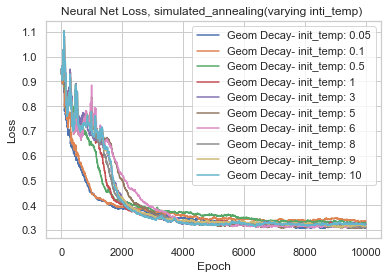

In [80]:
print("Setting up SA variables")
SA_classifier_accuracy = np.zeros(10)
SA_classifier_train_accuracy = np.zeros(10)
SA_time_train = np.zeros(10)
SA_time_infer = np.zeros(10)


j=0
for i in [0.05,0.1,0.5,1,3,5,6,8,9,10]:
    print(i)
    
    clf_sa = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu',
                                 algorithm = 'simulated_annealing', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
#                                  max_attempts = 100,
                                 random_state = 42,
                                 schedule= mlrose_hiive.ExpDecay(init_temp=i), curve=True)
    time_start = time.time()
    #nn_model5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    clf_sa.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
    fit_time = time.time()
    SA_time_train[j] = fit_time-time_start
    print(f'fit_time = {fit_time-time_start}')
    
    start_time = time.time()
    SA_classifier_train_accuracy[j]= recall_score(pd.get_dummies(y_train.values.ravel()).values, clf_sa.predict(X_train), average='macro')
    SA_classifier_accuracy[j] = recall_score(pd.get_dummies(y_test.values.ravel()).values, clf_sa.predict(X_test), average='macro')
    end_time = time.time()
    SA_time_infer[j] = end_time-start_time

    plt.plot(clf_sa.fitness_curve[:,0],label="Geom Decay- init_temp: "+str(i))
    plt.legend()
    fig=plt.gcf()
    j+=1
#fig.set_size_inches(10,6)
plt.title("Neural Net Loss, simulated_annealing(varying inti_temp) ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('../images/NN/nn_sa_lc.png')
plt.show()

In [81]:
SA_classifier_accuracy

array([0.87621553, 0.84999203, 0.84768054, 0.86808545, 0.86712897,
       0.82807269, 0.87940379, 0.86465806, 0.87039694, 0.8483979 ])

In [82]:
SA_classifier_train_accuracy

array([0.87860823, 0.86189331, 0.87297443, 0.85151396, 0.85766796,
       0.84098739, 0.85822251, 0.85499828, 0.85533199, 0.85433086])

<h3> Best SA Neural Network</h3>

In [29]:
best_clf_sa = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu',
                                 algorithm = 'simulated_annealing', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
#                                  max_attempts = 100,
                                 random_state = 42,
                                 schedule= mlrose_hiive.ExpDecay(init_temp=0.05), curve=True)
print('Running best_clf_rhc')
time_start = time.time()
best_clf_sa.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
fit_time = time.time()
ALL_time_train[3] = fit_time-time_start
print(f'fit_time = {fit_time-time_start}')
ALL_classifier_train_accuracy[3] = recall_score(pd.get_dummies(y_train.values.ravel()).values, best_clf_sa.predict(X_train), average='macro')   
start_time = time.time()
ALL_classifier_test_accuracy[3] = recall_score(pd.get_dummies(y_test.values.ravel()).values, best_clf_sa.predict(X_test), average='macro')
end_time = time.time()
ALL_time_infer[3] = end_time-start_time

Running best_clf_rhc
fit_time = 16.726036548614502


<h3> Comparing Best Neural Networks</h3>

In [32]:
ALL_classifier_train_accuracy

array([0.88364823, 0.77183099, 0.83620749, 0.87860823])

In [33]:
ALL_classifier_test_accuracy

array([0.8616292 , 0.76893034, 0.85979595, 0.87621553])

In [34]:
ALL_time_train

array([  21.0560298 ,  112.2417438 , 2824.1750598 ,   16.72603655])

In [35]:
ALL_time_infer

array([0.00200009, 0.0020051 , 0.0019989 , 0.00301504])

In [36]:
gd_classifier_train_accuracy, gd_classifier_test_accuracy, gd_time_train, gd_time_infer

(0.8836482308485056,
 0.8616292045273394,
 21.056029796600342,
 0.002000093460083008)

In [37]:
Algorithms = ('Gradient Descent','Genetic ALG', 'Random Hill Climb', 'Simulated Annealing')
ALL_classifier_train_accuracy=[0.88364823, 0.77183099, 0.83620749, 0.87860823]
ALL_classifier_test_accuracy= [0.8616292 , 0.76893034, 0.85979595, 0.87621553]
ALL_time_train= [  21.0560298 ,  1118.6131224632263 , 2824.1750598 ,   16.72603655]
ALL_time_infer= [0.00200009, 0.0020051 , 0.0019989 , 0.00301504]

In [38]:
df = pd.DataFrame()
df['Algorithms'] = Algorithms
df['Recall Score, Train'] = ALL_classifier_train_accuracy
df['Recall Score, Test'] = ALL_classifier_test_accuracy
df['Time Train'] = ALL_time_train
df['Time Infer'] = ALL_time_infer
df

,Algorithms,"Recall Score, Train","Recall Score, Test",Time Train,Time Infer
0,Gradient Descent,0.883648,0.861629,21.056030,0.002000
1,Genetic ALG,0.771831,0.768930,1118.613122,0.002005
2,Random Hill Climb,0.836207,0.859796,2824.175060,0.001999
3,Simulated Annealing,0.878608,0.876216,16.726037,0.003015


In [39]:
cm = sns.light_palette('green', as_cmap='True')
s = df.style.background_gradient(cmap=cm)
dfi.export(s, '../images/NN/Algo_table_compare.png')

In [40]:
s

,Algorithms,"Recall Score, Train","Recall Score, Test",Time Train,Time Infer
0,Gradient Descent,0.883648,0.861629,21.056030,0.002000
1,Genetic ALG,0.771831,0.768930,1118.613122,0.002005
2,Random Hill Climb,0.836207,0.859796,2824.175060,0.001999
3,Simulated Annealing,0.878608,0.876216,16.726037,0.003015


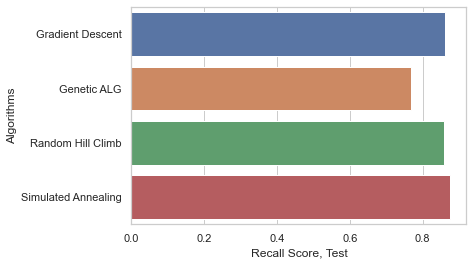

In [41]:
sns.set(style='whitegrid')
ax = sns.barplot(y='Algorithms', x= 'Recall Score, Test', data=df)
fig = ax.get_figure()
fig.savefig('../images/NN/Algo_score_compare.png')

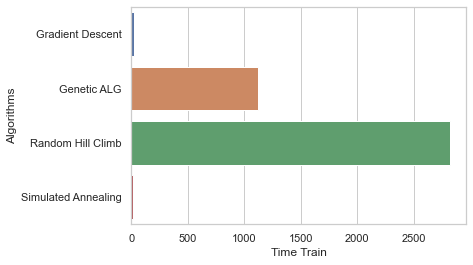

In [42]:
sns.set(style='whitegrid')
ax = sns.barplot(y='Algorithms', x= 'Time Train', data=df)
fig = ax.get_figure()
fig.savefig('../images/NN/Algo_time_compare.png')

<h3> Best Neural Networks Graphs</h3>

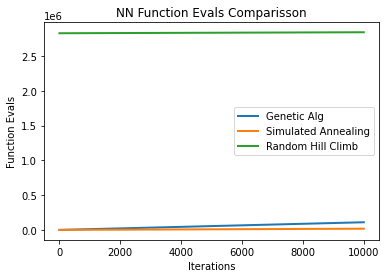

In [30]:
all_curves = {  "Genetic Alg": best_clf_ga.fitness_curve[:,1], "Simulated Annealing": best_clf_sa.fitness_curve[:,1], "Random Hill Climb": best_clf_rhc.fitness_curve[:,1]}

np.array([len(x) for x in all_curves]).max()

plt.xlabel("Iterations")
plt.ylabel("Function Evals")
plt.title("NN Function Evals Comparisson")

for name, curve in all_curves.items():
    plt.plot(range(len(curve)), curve, label=name, lw=2)

    plt.legend(loc="best")
plt.savefig('../images/NN/function_eval_cmparisson.png')
plt.show()

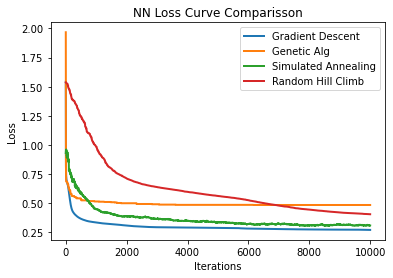

In [31]:
all_curves = { "Gradient Descent": best_clf_gd.fitness_curve *-1,"Genetic Alg": best_clf_ga.fitness_curve[:,0], "Simulated Annealing": best_clf_sa.fitness_curve[:,0], "Random Hill Climb": best_clf_rhc.fitness_curve[:,0]}

np.array([len(x) for x in all_curves]).max()

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("NN Loss Curve Comparisson")

for name, curve in all_curves.items():
    plt.plot(range(len(curve)), curve, label=name, lw=2)

    plt.legend(loc="best")
plt.savefig('../images/NN/loss_curve_cmparisson2.png')
plt.show()

<h1>Learning Curves of Best Algrithms</h1>

<h3>Learning Curve for Best Gradient Descent</h3>

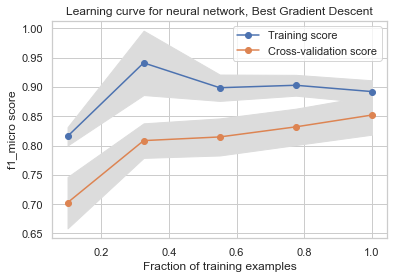

In [98]:
best_clf_gd_lc = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'gradient_descent', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.0001,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
#                                  pop_size=500,
#                                  mutation_prob=0.1
                                        curve=True)

train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_gd_lc, X_train, y_train, train_sizes=train_sizes, scoring='f1_micro', cv=5)

param_range=np.linspace(0.1, 1.0, 5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gainsboro")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title('Learning curve for neural network, Best Gradient Descent')
plt.xlabel('Fraction of training examples'), 
plt.ylabel("f1_micro score")
plt.legend(loc="best")
plt.grid(visible=True)
plt.savefig('../images/NN/best_gd_nn_learningCurve.png')
plt.show()

<h3>Learning Curve Best Simulated Annealing</h3>

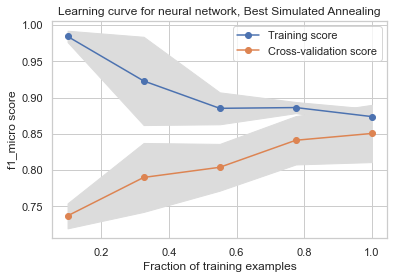

In [99]:
best_clf_sa_lc = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu',
                                 algorithm = 'simulated_annealing', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
#                                  max_attempts = 100,
                                 random_state = 42,
                                 schedule= mlrose_hiive.ExpDecay(init_temp=0.05), curve=True)

train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_sa_lc, X_train, y_train, train_sizes=train_sizes, scoring='f1_micro', cv=5)

param_range=np.linspace(0.1, 1.0, 5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gainsboro")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title('Learning curve for neural network, Best Simulated Annealing')
plt.xlabel('Fraction of training examples'), 
plt.ylabel("f1_micro score")
plt.legend(loc="best")
plt.grid(visible=True)
plt.savefig('../images/NN/best_sa_nn_learningCurve.png')
plt.show()

<h3>Below Learning Curves for Best RHC and Best GA, runs a long time</h3>

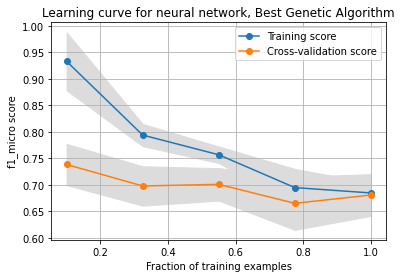

In [15]:
best_clf_ga_lc = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
                                 pop_size=1000,
                                 mutation_prob=0.1, curve=True)


train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_ga_lc, X_train, y_train, train_sizes=train_sizes, scoring='f1_micro', cv=5)

param_range=np.linspace(0.1, 1.0, 5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gainsboro")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title('Learning curve for neural network, Best Genetic Algorithm')
plt.xlabel('Fraction of training examples'), 
plt.ylabel("f1_micro score")
plt.legend(loc="best")
plt.grid(visible=True)
plt.savefig('../images/NN/best_ga_nn_learningCurve.png')
plt.show()

In [ ]:
best_clf_rhc_lc = mlrose_hiive.NeuralNetwork(hidden_nodes = [4,4], activation = 'relu',
                                 algorithm = 'random_hill_climb', 
                                 max_iters = 10000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.01,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 44,
#                                  pop_size=200,
                                 restarts =50, curve=True)

train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_rhc_lc, X_train, y_train, train_sizes=train_sizes, scoring='f1_micro', cv=5)

param_range=np.linspace(0.1, 1.0, 5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gainsboro")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title('Learning curve for neural network, Best Random Hill Climb')
plt.xlabel('Fraction of training examples'), 
plt.ylabel("f1_micro score")
plt.legend(loc="best")
plt.grid(visible=True)
plt.savefig('../images/NN/best_rhc_nn_learningCurve.png')
plt.show()